# Stock Picking 
## Group 1 ML Part II Coursework


Stock picking has been a long practice in the market where mutual funds have clamied they can beat the market. The claim has been debated since the Princeton professor Burton Malkiel said expert's stock picks peform as well as blind monkeys throwing darts. Some have even demonstrated the monkey even did a better job than the experts.

https://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#24c34e92630a

Here we try to use Machine Learning classifier to beat the monkey's performance. Since it is illegal to own one, we simulate the monkey by a random picking algorithm. 

In [2]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Data Collection and Structuring
First we structure the data. We collected stocks listed on NYSE and NASDAQ fundamental financial ratios of Q4 2017 as features (X) as well as price information of Q4 2017-18 from Bloomberg. We drop the Nan when Bloomberg has no available data. Bloomberg is the lead market participant in financial data provider. If they don't have the information, it is doubtful that other data vendor (FACTSET, Reuters) has it. We split the data by the built-in function that exists in sklearn. The reason behind it is that the function probably handles splitting the data a lot better than we would have and it is better practice to not re-write and use already existing code.

In [3]:
df = pd.read_csv("./resources/2018.csv")
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,Symbol,cash_ratio,return_to_equity,price_to_book,pe,short_interest_ratio,debt_to_equity,eps,last_price,previous_year_price
0,MMM,0.4571,37.66730402,10.519554,25.3366,2.959,142.6619,1.01,199.15,236.58
1,WUBA,0.9377,7.842562916,3.466236,247.7696,1.584,4.1318,1.18,69.68,68.93
2,EGHT,4.0372,-41.19122937,7.989302,31.7871,2.115,0.0000,-0.14,19.775,14.10
3,AHC,1.6529,12.38072109,1.109514,971.1333,1.213,0.0000,-0.19,4.75,4.85
4,AAC,0.3138,-12.45305726,1.540616,12.3618,14.426,193.2304,-0.01,9.86,9.11


Picking the financial ratios was part of the feature engineering that we had to do for this project. As one might know, there are a number of financial ratios that can describe the fundamental state of company. They usually contain information about the health/growth/profitability of the company, which are all important factors for the company and if an investor feels it is good enough to invest in.

We chose the ratios based on the 2 following factors:
    1) Popularity (among investors)
    2) Availability from our data source (Bloomberg)
    
As far as 1) goes, the ratios we picked were favourites among fundamental investors. They have been known to be used for fundamental analysis for many years and seem to describe a company and it's future performance well. There are a number of other factors/ratios that we wanted to use, to further the analysis, however our data vendor either kept running out of data, or there was not enought coverage of those ratios for the companies we selected.

### Label Outperforming and Underperfoming the market 
The market return is defined as the 1 year log return of the market. Stock is labelled "outperform" or "1" when its 1 year log return is bigger than its respective market return(NYSE or NASDAQ). Stock is labelled "underperform" or "0" vice versa.

In [4]:
nyse_previous_close = 12412.07
nyse_one_year_close = 11812.20

nasdaq_previous_close = 7712.9502
nasdaq_one_year_close = 6233.9502

nasdaq_begin_index = 977

nyse_performance = math.log(nyse_previous_close/nyse_one_year_close)
nasdaq_performance = math.log(nasdaq_previous_close/nasdaq_one_year_close)

df = df.infer_objects()
df['last_price'] = df['last_price'].astype('float')

df['performance'] = np.log(df['last_price'] /df['previous_year_price'])
df['status'] = 0
nyse_performance = (df.loc[range(0,nasdaq_begin_index),'performance']>nyse_performance).astype('int')
nasdaq_performance = (df.loc[range(nasdaq_begin_index,len(df)),'performance']>nasdaq_performance).astype('int')
df['status'] = nyse_performance
df.loc[nasdaq_begin_index:len(df),'status'] = nasdaq_performance
df['status'] = df['status'].astype('int')
df.dropna() 
df.head()

,Symbol,cash_ratio,return_to_equity,price_to_book,pe,short_interest_ratio,debt_to_equity,eps,last_price,previous_year_price,performance,status
0,MMM,0.4571,37.66730402,10.519554,25.3366,2.959,142.6619,1.01,199.150,236.58,-0.172228,0
1,WUBA,0.9377,7.842562916,3.466236,247.7696,1.584,4.1318,1.18,69.680,68.93,0.010822,0
2,EGHT,4.0372,-41.19122937,7.989302,31.7871,2.115,0.0000,-0.14,19.775,14.10,0.338244,1
3,AHC,1.6529,12.38072109,1.109514,971.1333,1.213,0.0000,-0.19,4.750,4.85,-0.020834,0
4,AAC,0.3138,-12.45305726,1.540616,12.3618,14.426,193.2304,-0.01,9.860,9.11,0.079113,1


### Train and Test Data Split using sklearn

The function train_test_split uses a merge of Stratified K-fold and ShuffleSplit to split the data in train and test set. 

Specifically, stratified K-fold makes sure there is correct representation of both classes in all folds and thus in both sets. This implies that there is going to be balance in both sets regarding the representation of each class.

Shuffle split simply creates a permutation of a set based on the random seed that is set.

We could not generate a validation set as the total data set was only 1840 data points. Needing a good enough train set and a good representation for the test set, we felt (and verified) that a validation set would be redundant and would only harm the overall efficiency of the algorithms and the results.

In [5]:
X = df[['cash_ratio','return_to_equity','price_to_book',
        'pe','short_interest_ratio','debt_to_equity','eps']]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, shuffle=True, stratify=y)


## Exploratory Data Analysis

The labelled data seems to slightly tilited to "underperform" based on the less than 0.5 mean for both train and test data sets. Features overall varies in a large range within individual stock's features and across. We have the following as features<br>
Cash ratio $\frac{cash \ and \ cash \ equivalents }{total \ asset}$. This measures the company's most liquid assets. There is a sweetspot as companies want to invest so it needs enough cash.<br>
Price to book $\frac{Market \ capitalisation}{Book \ Value}$. This measures the market value of the company compare to its book value(owned asset - liability). High ratio could mean the market is overvaluing the company.<br>
Price to Earning $\frac{share \ price}{earning \ per \ share}$. Market price to company's earning, usually low means high growing potential.<br>
Short interest ratio $\frac{shares \ which \ have \ been \ shorted \ or \ unsold}{trading \ volume}$. The amount that bets against the company. <br>
Debt to Equity $\frac{Total \ Debt}{Book \ Equity}$ The higher the ratio, the more the company is leveraged.<br>
EPS earning per share. Earnings per shares outstanding.<br>

Since the data is not sequential/ time-series, there is no need of forward chaining. However the release of the financial ratios might not matches the return (whether the stock return outperform/ underperform the market) info at the exact same date. It is very difficult to pinpoint a date where all price info and financial ratios are available. We accept the shortcoming and proceed. 

In [6]:
X_test.describe()

,cash_ratio,price_to_book,pe,short_interest_ratio,debt_to_equity,eps
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,1.028137,25.084688,41.346297,6.124573,284.298935,6.285068
std,2.272746,379.182554,94.352842,6.077265,2773.999106,99.890417
min,0.000200,0.073257,0.780000,0.056000,0.000000,-9.870000
25%,0.133225,1.555604,16.277900,2.368250,18.062250,0.150000
50%,0.442200,2.517129,22.119150,4.073500,66.506150,0.640000
75%,1.065575,4.336916,33.644325,7.517250,126.426300,1.495000
max,31.522900,7271.903912,1121.748500,43.332000,51000.000000,1916.706200


In [7]:
X_train.describe()

,cash_ratio,price_to_book,pe,short_interest_ratio,debt_to_equity,eps
count,1472.000000,1472.000000,1.472000e+03,1472.000000,1472.000000,1472.000000
mean,1.225592,5.007646,1.878540e+03,6.234643,119.072600,1.240309
std,3.397330,24.835289,6.981861e+04,6.487965,413.624558,5.456003
min,0.000000,0.003900,6.000000e-04,0.042000,0.000000,-125.700000
25%,0.150900,1.616033,1.685785e+01,2.447000,16.321900,0.140000
50%,0.455450,2.543800,2.334905e+01,4.273500,59.004850,0.610000
75%,1.163725,4.327185,3.742260e+01,8.308000,119.859325,1.510000
max,66.235500,826.661655,2.678750e+06,108.744000,13352.430000,81.360000


In [8]:
y_train.describe()

count    1472.000000
mean        0.417120
std         0.493251
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: status, dtype: float64

In [9]:
y_test.describe()

count    368.000000
mean       0.415761
std        0.493524
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: status, dtype: float64

## Performance Metrics
Assuming we are "the experts" of a long only fund. We would like to minimise our number of bad choices and maximise our number of good choices, "False Positive" and "True Positive" (since we don't short underperforming stocks). We originally thought to use precision as our performance metric. 

$Precision = \frac{True \ Positive}{True  \ Positive \ + \ False \ Positive}$

However, this leads us to models which are strictly predict negative(underperform) with only one positive(overpeform). We opt for the F1 score by considering both the precision and recall. They are defined as:

$Recall = \frac{True \ Positive}{True  \ Positive \ + \ False \ Negative}$

$F_1 = 2 \frac{Precision \ \cdot \ Recall }{Precision + Recall }$

In [10]:
def F1_score(confusion_matrix):
    v = np.array(confusion_matrix)
    TN, FP, FN, TP = v.flatten()
    prec = TP/ (TP + FP)
    recall = TP/ (TP + FN)
    F1 = 2*(prec*recall)/(prec+recall)
    return F1

In addition, we calculate the confusion matrix for each model:  
    $ \ A  = \begin{pmatrix} 
True \ Negative & False \ Positive \\
False  \ Negative & True \ Positive
\end{pmatrix}$

In [11]:
def confusion_matrix_for_reg(predict, real):
    
    ## when running regression, we expect the predict performance would not consists only 1 or 0. 
    ## We round the predicted performance to the first decimal
    predict = np.array(np.round(predict))

    
    ## Since the underlying model is a regression, we also limit the prediction between 0 and 1
    predict = predict.clip(min=0, max=1)
    
    real = np.array(real)


    ## use AND gate to check for TP
    TP = np.sum(np.logical_and(predict, real))
    ## FP = sum of all 1s in predict - TP  
    FP = np.sum(predict ==1) - TP


    ## first flip predict and real 1 and 0s, and use the same AND gate to check for TN
    TN = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(real)))
    FN = np.sum(predict ==0) - TN



    conf_matrix = [[TN, FP], [FN, TP]]


    return conf_matrix

### Monkey stock picking
We simulate the monkey stock picking by randomly choosing under or overperform for each stock. This is our first naive method as stocks are simply picked by random, diregarding their fundamental financial ratios.


In [12]:
np.random.seed(2018)
y_train_from_random = np.random.uniform(1,0,len(y_train))

y_test_from_random = np.random.uniform(1,0,len(y_test))

### OLS regression 

Regression analysis helps one understand how the typical value of the dependent variable (or 'criterion variable') changes when any one of the independent variables is varied, while the other independent variables are held fixed. 

One of the textbook methods of fundamental analysis is an OLS regression(fundamental model) to model stock performance. OLS can be seen as our second naive method as we assume there the relationships between features and the stock performance are linear. The loss function to be minimised is

$arg \ min_{\beta} ||y - X  \ \beta \ ||_{2}^2$

y is the labelled data, 1 and 0 representing performance in our case. X represents the matrix of features with $\beta$ as the regression coefficients. The loss function of OLS represents the sum of squared errors/ residuals. 

The first model is fitted with the train data set to predict train performance. The second model is first fitted with validation data set and used to predict the test performance. 

## Normalising Data
We will normalise the data before fitting the model. It is essential to normalise the data especially for penalised regression as the regressions are non-invariant. We would not want feature which varies a lot carry more weight than those which don't. 

In [13]:
def model_OLS(data_X_train, data_y_train, data_X_test):
    # can change with or without intercept/ normalize
    linreg = linear_model.LinearRegression(fit_intercept=True, normalize=True)  
    linreg.fit(data_X_train, data_y_train)
    linreg.get_params()
    y_train_from_OLS = linreg.predict(data_X_train)
    y_test_from_OLS =  linreg.predict(data_X_test)
    
    return y_train_from_OLS, y_test_from_OLS

### LASSO regression
The LASSO regression is a penalised regression where 

$arg \ min_{\beta} ||y - X  (\beta) \ ||_{2}^2 + \lambda \ || \beta ||_1$

is the loss function to be minimised. The first term is to reduce bias and the second term is to reduce variance. $\lambda$ is the penalised coefficient for increased complexity. The larger the $\lambda$, the heavier the penality to increase the model to a polynomial. 

In [14]:
def model_Lassi(data_X_train, data_y_train, a):
    Lassi = Lasso(alpha=a, tol=1e-5, normalize=True)
    Lassi.fit(data_X_train, data_y_train)
    
    y_train_from_LASSO = Lassi.predict(data_X_train)

    return y_train_from_LASSO

### Ridge regression

The Ridge regression is a penalised regression where 

$arg \ min_{\beta} ||y - X  ( \beta ) \ ||_{2}^2 + \lambda \ || \beta ||^2_{2}$

is to be minimised. The difference between LASSO and Ridge is the penality term for increasing complexity is squared instead of absoluted in Ridge. LASSO's regularisation is L1 instead of L2 regularisation in Ridge. This allows LASSO to shrinks the irrelevant features to zero. 

In [15]:
def model_Rachel(data_X_train, data_y_train, a):
    Rachel = Ridge(alpha=a, tol=1e-5, normalize=True)
    Rachel.fit(data_X_train, data_y_train)
    y_train_from_Ridge = Rachel.predict(data_X_train)

    return y_train_from_Ridge

### Run OLS regression

In [16]:
y_train_from_OLS, y_test_from_OLS = model_OLS(X_train, y_train, X_test)

conf_matrix_train_from_OLS = confusion_matrix_for_reg(y_train_from_OLS, y_train)

F1_score_train_from_OLS = F1_score(conf_matrix_train_from_OLS)

conf_matrix_test_from_OLS = confusion_matrix_for_reg(y_test_from_OLS, y_test)

F1_score_test_from_OLS = F1_score(conf_matrix_test_from_OLS)

### Optimising lambda for the penalised regression models
The amount of penality with increased compexity is adjusted by $\lambda$. The optimal $\lambda$ is chose based on the the F1 score of the model fitted with the training set. The F1 score is based on precision and recall, which are obtained from the confusion matrix. 

In [17]:
## TODO Optimizing LASSO and Ridge Lambda

## initialising

# range of lambda we are testing
x_axis_interval = np.arange(0,1, 1e-3)

# lists of F1 scores

F1_train_LASSO =[]
F1_train_Ridge =[]


## finding optimal lambda for the least amount of False Positive
for a in x_axis_interval:

    y_train_from_LASSO = model_Lassi(X_train, y_train, a)
    
    ## Calculate the F1 score and append the score list
    
    F1_train_from_LASSO = F1_score(confusion_matrix_for_reg(y_train_from_LASSO, y_train))
    F1_train_LASSO.append(F1_train_from_LASSO)
    
    y_train_from_Ridge = model_Rachel(X_train, y_train, a)
    
    F1_train_from_Ridge = F1_score(confusion_matrix_for_reg(y_train_from_Ridge, y_train))
    F1_train_Ridge.append(F1_train_from_Ridge)


/Users/King/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/King/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/King/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/King/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


### Precision across lambdas

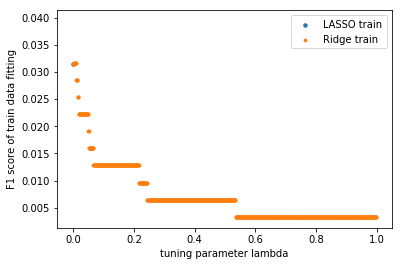

In [18]:
# Plotting the precisions across lambdas
plt.scatter(x_axis_interval,F1_train_LASSO, label="LASSO train", s=12)
plt.scatter(x_axis_interval,F1_train_Ridge, label="Ridge train", s=8)

plt.xlabel('tuning parameter lambda')
plt.ylabel('F1 score of train data fitting')
plt.legend()
plt.show()

The reason behind precision of 1 for Ridge train is there was only one true positiive with no false positve. This is misleading as we compensating with lots of False negative. 

### Optimal model with optimal lambda for predicting from test data set
We chose the optimal $\lambda$ according to the precisison of the model. We retrain the model with the validation data set and the optimal $\lambda$ to predict using test data.

In [19]:
a_range = x_axis_interval

## Only optimize for minimum FP, long only fund
F1_train_from_LASSO = np.array(F1_train_from_LASSO)
F1_train_from_Ridge = np.array(F1_train_from_Ridge)
opt_lambda_LASSO = a_range[np.argmax(F1_train_from_LASSO)]
opt_lambda_Ridge = a_range[np.argmax(F1_train_from_Ridge)]

## predicting test data set with optimal lambda/ alpha, returning confusion matrix
Lassi_opt = Lasso(alpha=opt_lambda_LASSO, tol=1e-5)
Lassi_opt.fit(X_train, y_train)
y_test_from_Lassi = Lassi_opt.predict(X_test)

F1_test_from_Lassi = F1_score(confusion_matrix_for_reg(y_test_from_Lassi,y_test))


Rachel_opt = Ridge(alpha=opt_lambda_Ridge, tol=1e-5)
Rachel_opt.fit(X_train, y_train)
y_test_from_Rachel = Rachel_opt.predict(X_test)

F1_test_from_Rachel = F1_score(confusion_matrix_for_reg(y_test_from_Rachel, y_test))


/Users/King/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # This is added back by InteractiveShellApp.init_path()
/Users/King/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/King/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [20]:
print("optimal lambda/ tuning parameters for LASSO:", opt_lambda_LASSO,"\noptimal lambda/ tuning parameters for Ridge:", opt_lambda_Ridge)
## TODO Performance metric, calculating F1 score
## first get F1 score of randomly picking

F1_train_from_random = F1_score(confusion_matrix_for_reg(y_train_from_random, y_train))
F1_test_from_random = F1_score(confusion_matrix_for_reg(y_test_from_random, y_test))




F1_score_list = [F1_train_from_random, F1_test_from_random,
                    F1_score_train_from_OLS, F1_score_test_from_OLS,
                    F1_test_from_Lassi, F1_test_from_Rachel]
    
    
    
name_label = ["train_from_random", "test_from_random",
                    "train_from_OLS", "test_from_OLS",
                    "test_LASSO", "test_Ridge"]

test_F1 = pd.DataFrame([F1_score_list], columns=name_label)
# test_precision.set_index("Precision")




optimal lambda/ tuning parameters for LASSO: 0.0 
optimal lambda/ tuning parameters for Ridge: 0.0


## Regression f1 Results

In [21]:
test_F1

,train_from_random,test_from_random,train_from_OLS,test_from_OLS,test_LASSO,test_Ridge
0,0.458333,0.481159,0.031546,0.084848,0.084848,0.084848


It seems the optimal lambda is exactly 0 for LASSO and almost 0 for Ridge regression, converging back to an OLS regression. Indicating there is no advantage to increase the model complexity.

## Cross validation and Ridge Classifier for further improvement

We also did a k fold cross validation of the three regression as we feel a single split of training and testing data does not represent the data entirely. K fold cross validation works by randomly assigning data into bins evenly and iteratively select one as the test set, the rest as the training set. This is coded as a python script, "stock_pred_kfold.py" due to the massive loop. The F1 results are presented below

In [22]:
pd.DataFrame([[0.44871059, 0.48334576, 0.00944125, 0.01253388, 0.01253388, 0.01253388]], columns=name_label)

,train_from_random,test_from_random,train_from_OLS,test_from_OLS,test_LASSO,test_Ridge
0,0.448711,0.483346,0.009441,0.012534,0.012534,0.012534


When comparing the F1 scores across model's test prediction, all linear model performed terribly and lost to the monkey. We can conclude from the that regression might not be the best model to use, which is logical as this is a classification problem. Rounding to or limiting between 1 and 0 is not the best solution when interpreting the predictions from using regression model. 

# SVM: Support Vector Machine

The SVM is a machine learning technique most often utilized for classification. The goal of the learning technique is to draw a hyperplane(in linear 2D SVM this would be a line) between data that is distinctly classified in different categories. The best choice will be the hyperplane that leaves the maximum margin from both classes. The goal of the svm algorithm is to maximize the separability between the data points and the hyperplane.
<br><br>
Any hyperplane can be written as $w \cdot x - b = 0$, and having a binary classification of -1,1 yields the following 2 equations $w \cdot x - b = -1$ and $w \cdot x - b = 1$. Geometrically, the distance between these 2 lines (margin) is $\frac{2}{||w||}$. The job of the classifier is to minimize this fraction with the constraints of correct classification. More concretely, the minimization that needs to take place is $\min_{w}||w||^2$ with the constraint of $y_i(w^Tx_i+b) >= 1$
<br><br>
In general, there is a trade off between the margin and the number of mistakes on the data i.e. the points can be linearly separated but there is a narrow margin or the margin solution is better even though some constraints might be violated. As a result, slack variables can be introduced ($\xi$), which would control the aforementioned effect. Thus we reach a "soft" margin solution where the optimization becomes $\min_{w}||w||^2 + C\sum_{i}^{N}\xi_i$ subject to $y_i(w^Tx_i+b) >= 1-\xi_i$, where C is a regularization parameter.
<br><br>
Rewriting the the constraint $y_i(w^Tx_i+b) >= 1-\xi_i$ as $y_if(x_i)>=1-\xi_i$ and with $\xi_i>0$ we get $\xi_i=max(0,1-y_if(x_i)$, which makes our problem an uncostrainted optimization over w of the form: $\min_{w}||w||^2+C\sum_{i}^{N}\max(0,1-y_if(\xi_i))$ with the second part of the equation being the loss function.
<br><br>
Our problem is perfect for an SVM as its main function is to classify companies as underperforming or overperforming. Minimizing the loss function would create a hyperplane that would distinguish between overperforming and underperforming companies. 
<br><br>
In terms of hyperparameters, the svm has 2 main ones. The C and the gamma. Following https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, we set the range of the hyperparameters accordingly. Finally, since it is hard to visualize what our dataset would look like, we added another hyperparameter which was the kernel of the svm. We excluded the polynomial kernel, as it took a very long time to train and fit the data.

More specifically C controls the missclassification of the data. C, depending on its value would trade error penalty for stability.Gamma is mostly used for non-linear kernels. Usually high gamma leads to high bias and low variance.
<br><br>
The metrics that were used for the data are similar to the regressions.



In [22]:
#variable to hold our hyper-parameter results.
results = pd.DataFrame(columns=['C','gamma','algo','test_precision','test_recall','train_precision','train_recall'],index=range(1000000))

df = df.dropna()
df = df.reset_index(drop=True)

## formatting the input and the expected output we get
X = df[['cash_ratio','return_to_equity','price_to_book','pe','short_interest_ratio','debt_to_equity','eps']]
y = df['status']

The following functions are defined in order to help with the production of the outputs of the SVM. Product metrics produces the confusion metrics via the built-in function and the precision as well as the recall.

The run model splits the dataset into train and validation set and trains the SVM model, as well as predicting using both the train and validation set. The function was created in order to use hyper-parametrization on the important variables.

In [23]:
def product_metrics(real, pred):
    #print("Non 0 results " + str(sum(pred != 0)) + " ,0 results " + str(sum(pred == 0)))
    C = confusion_matrix(real, pred)
    tn, fp, fn, tp = C[0, 0], C[0, 1], C[1, 0], C[1, 1];
    try:
        precision = float(tp) / float((tp + fp))
    except(ZeroDivisionError):
        precision = 0
    try:
        recall = float(tp) / float((tp + fn))
    except(ZeroDivisionError):
        recall = 0
    #print("Precision " + str(precision) + " Recall " + str(recall))
    return precision,recall

def run_model(C,gamma,algo):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, shuffle=True, stratify=y)
    clf = svm.SVC(kernel=algo,C=C,gamma=gamma)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    train_precision, train_recall = product_metrics(y_train, train_pred)
    test_precision, test_recall = product_metrics(y_test, test_pred)

    return C,gamma,algo,train_precision,train_recall,test_precision,test_recall


This specific piece of code takes a long time to run which is why the results are saved in a csv. The results are going to be uploaded for further examination. To produce the content in results.csv uncomment the commented lines and comment the Cs and gammas lines.

In [ ]:
## WARNING: EVEN THE SHORT VERSION TAKES TIME TO COMPLETE
#gammas = [2**x for x in range(-10,10,2)]
#Cs = [2**x for x in range(-10,10,2)]
Cs = [10,100,1000]
gammas = [0.1,0.2,0.5]
algos = ['linear','rbf','sigmoid']

counter = 0
for algo in algos:
    for c in Cs:
        for gamma in gammas:
            results.iloc[counter] = run_model(c,gamma,algo)
            print(results.iloc[counter])
            counter = counter+1;

#results.to_csv('./resources/results.csv', sep=',')

C                         10
gamma                    0.1
algo                  linear
test_precision      0.608108
test_recall        0.0732899
train_precision          0.5
train_recall       0.0915033
Name: 0, dtype: object
C                         10
gamma                    0.2
algo                  linear
test_precision      0.608108
test_recall        0.0732899
train_precision          0.5
train_recall       0.0915033
Name: 1, dtype: object
C                         10
gamma                    0.5
algo                  linear
test_precision      0.608108
test_recall        0.0732899
train_precision          0.5
train_recall       0.0915033
Name: 2, dtype: object


Plotting hyper-parameterization variables.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: Settin

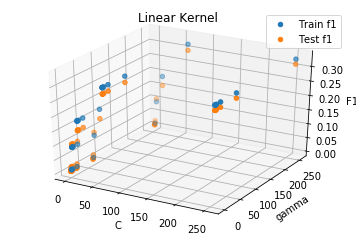

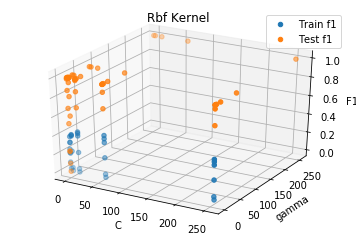

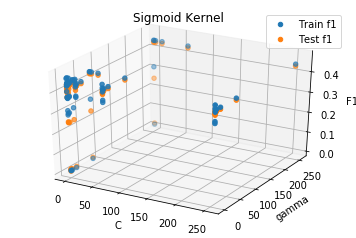

In [24]:
results = pd.read_csv("./resources/results.csv")

linear = results.iloc[np.where(results['algo']=='linear')]
rbf = results.iloc[np.where(results['algo']=='rbf')]
sigmoid = results.iloc[np.where(results['algo']=='sigmoid')]

linear['f1_train'] = 2*((linear['train_precision']*linear['train_recall'])/(linear['train_precision']+linear['train_recall']))
linear['f1_test'] = 2*((linear['test_precision']*linear['test_recall'])/(linear['test_precision']+linear['test_recall']))

rbf['f1_train'] = 2*((rbf['train_precision']*rbf['train_recall'])/(rbf['train_precision']+rbf['train_recall']))
rbf['f1_test'] = 2*((rbf['test_precision']*rbf['test_recall'])/(rbf['test_precision']+rbf['test_recall']))

sigmoid['f1_train'] = 2*((sigmoid['train_precision']*sigmoid['train_recall'])/(sigmoid['train_precision']+sigmoid['train_recall']))
sigmoid['f1_test'] = 2*((sigmoid['test_precision']*sigmoid['test_recall'])/(sigmoid['test_precision']+sigmoid['test_recall']))

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(linear['C'], linear['gamma'], linear['f1_train'], label='Train f1')
ax.scatter(linear['C'], linear['gamma'], linear['f1_test'], label='Test f1')
ax.legend()
ax.set_title("Linear Kernel")
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('F1')

fig1 = plt.figure()
ax1 = fig1.gca(projection='3d')
ax1.scatter(rbf['C'], rbf['gamma'], rbf['f1_train'], label='Train f1')
ax1.scatter(rbf['C'], rbf['gamma'], rbf['f1_test'], label='Test f1')
ax1.legend()
ax1.set_title("Rbf Kernel")
ax1.set_xlabel('C')
ax1.set_ylabel('gamma')
ax1.set_zlabel('F1')

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.scatter(sigmoid['C'], sigmoid['gamma'], sigmoid['f1_train'], label='Train f1')
ax2.scatter (sigmoid['C'], sigmoid['gamma'], sigmoid['f1_test'], label='Test f1')
ax2.legend()
ax2.set_title("Sigmoid Kernel")
ax2.set_xlabel('C')
ax2.set_ylabel('gamma')
ax2.set_zlabel('F1')

plt.show()


The best results for each kernel are demonstrated below:

In [25]:
linear['f1'] = linear['f1_train']+linear['f1_test']
rbf['f1'] = rbf['f1_train']+rbf['f1_test']
sigmoid['f1'] = sigmoid['f1_train']+sigmoid['f1_test']

linear_best_f1 = linear.loc[linear['f1'].idxmax()]
rbf_best_f1 = rbf.loc[rbf['f1'].idxmax()]
sigmoid_best_f1 = sigmoid.loc[sigmoid['f1'].idxmax()]

print("BEST F1")
print("Linear------\n" +str(linear_best_f1))
print("Rbf------\n"+str(rbf_best_f1))
print("Sigmoid------\n"+str(sigmoid_best_f1))

BEST F1
Linear------
Unnamed: 0                  90
C                          256
gamma              0.000976562
algo                    linear
test_precision        0.537849
test_recall            0.21987
train_precision       0.464286
train_recall          0.254902
f1_train              0.329114
f1_test               0.312139
f1                    0.641253
Name: 90, dtype: object
Rbf------
Unnamed: 0              172
C                        16
gamma              0.015625
algo                    rbf
test_precision     0.986992
test_recall        0.988599
train_precision    0.452381
train_recall       0.372549
f1_train           0.408602
f1_test            0.987795
f1                   1.3964
Name: 172, dtype: object
Sigmoid------
Unnamed: 0                 260
C                            4
gamma              0.000976562
algo                   sigmoid
test_precision        0.439935
test_recall           0.441368
train_precision       0.507692
train_recall          0.431373
f1_train 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

It is clear that the rbf provides the best f1 overall score. This is not the case just for the best score out of the 3, but in general overall. It should be noted that the addition of the train and test f1 score is taken into account, as there exist f1 scores in the test set where the f1 score is 1, but with terrible test set f1 scores. In general, a model that predicts data in both sets is more desirable which is the reason behind the addition.

## Final conclusion

In general, we found that regression methods do not yield great results when it comes to predicting the class. The penalized regressions(LASSO and Ridge) end up converging to a standard OLS regression, as the best models have lambda=0. As explained, this is to be expected. SVM, being a classifier, produces more meaningful results with the rbf kernel performing (in general) better than the other kernels. Via hyper-parameterization we find that the best hyper-parameters for the rbf kernel are C=16 and gamma = 0.015625. Exploring the most important features for the svm cannot be determined unfortunately, as the rbf does not produce any concrete coefficients.

It should also be noted that in the regression, we did not add the f1 scores of the train and test set, as we did for the SVM. This was because the results were pretty abysmal so we felt that there would not be any benefit by doing this. Even if a better model was discovered, its performance would not be on par with the svm.

The toughest problem we had to face in this project was the lack and the structure of data. Even using Bloomberg, we had trouble retrieving data without missing information, something which plagued our data set. Throughout this process, we discovered that even though understanding the theory and being able to apply it is very important, having the best data and the best representation of it is the most important part.

As far as improvements go, adding more features would definitely benefit the result as the description of the companies would be much better and having more and reliable data would also add a lot of value.

